# COVID19 Global Timeseries data
Source: [JHU CSSE](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('ggplot')
#plt.rcParams
%matplotlib inline

In [2]:
confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
covid_confirmed = pd.read_csv(confirmed_cases_url)

recovered_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
covid_recovered = pd.read_csv(recovered_cases_url)

deceased_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
covid_deceased = pd.read_csv(deceased_cases_url)

In [3]:
def modify_df(_df):
    # Drop Latitude and Longitude
    _df.drop(['Lat', 'Long'], axis=1, inplace=True)
    
    # Create multiindex
    country_df = _df.filter(['Country/Region', 'Province/State'], axis=1)
    
    # Change the index
    _df.index = pd.MultiIndex.from_frame(country_df)
    del country_df
    
    # Groupby country and sum up the cases
    _df = _df.groupby(level="Country/Region").sum()
    
    # Return a Transposed df which is in a more readable format
    return _df.transpose()   

In [4]:
def status_by_country(_country):
    
    plt.figure(figsize=(20,10))
    plt.plot(covid_confirmed[_country], 'b*-', label='Confirmed')
    plt.plot(covid_recovered[_country], 'g+-', label='Recovered')
    plt.plot(covid_deceased[_country], 'ro-', label='Deceased')
    plt.legend(loc='best')
    plt.xticks(rotation=45);
    plt.grid(alpha=0.75)
    plt.title(_country +' - COVID19 cases till date');

In [5]:
def daily_cases_by_country(_country):
    
    _df = covid_confirmed[_country]
    _df = _df.diff()
    _df.plot(kind='bar', figsize=(20,10), title=_country+' - COVID19 cases by day')
    plt.xticks(rotation=45);

In [6]:
covid_confirmed = modify_df(covid_confirmed)
covid_recovered = modify_df(covid_recovered)
covid_deceased = modify_df(covid_deceased)

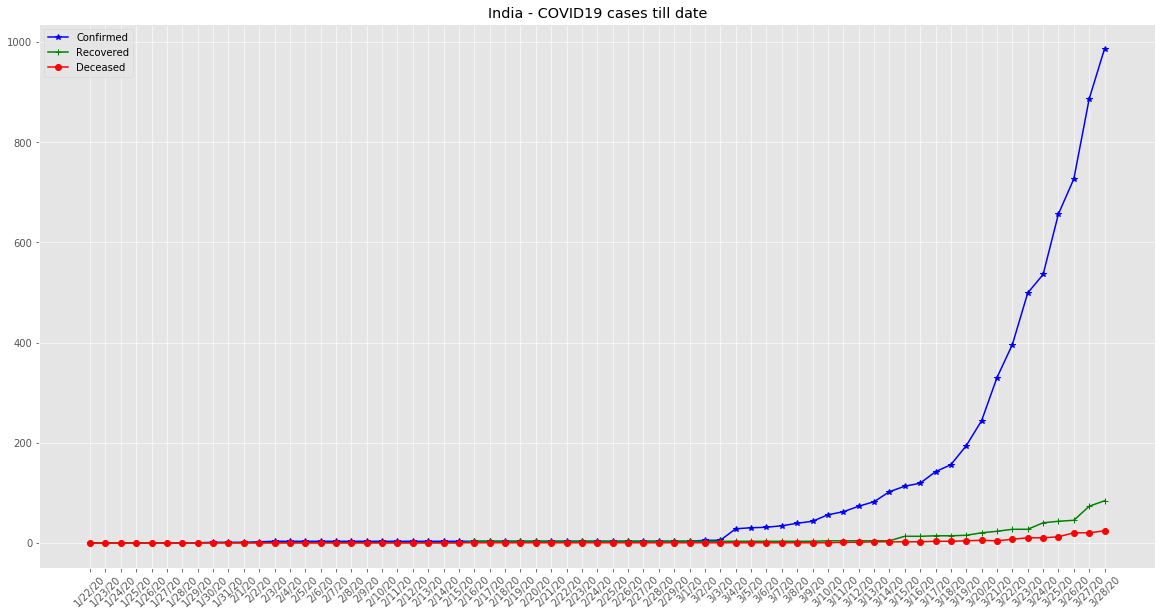

In [22]:
status_by_country('India')

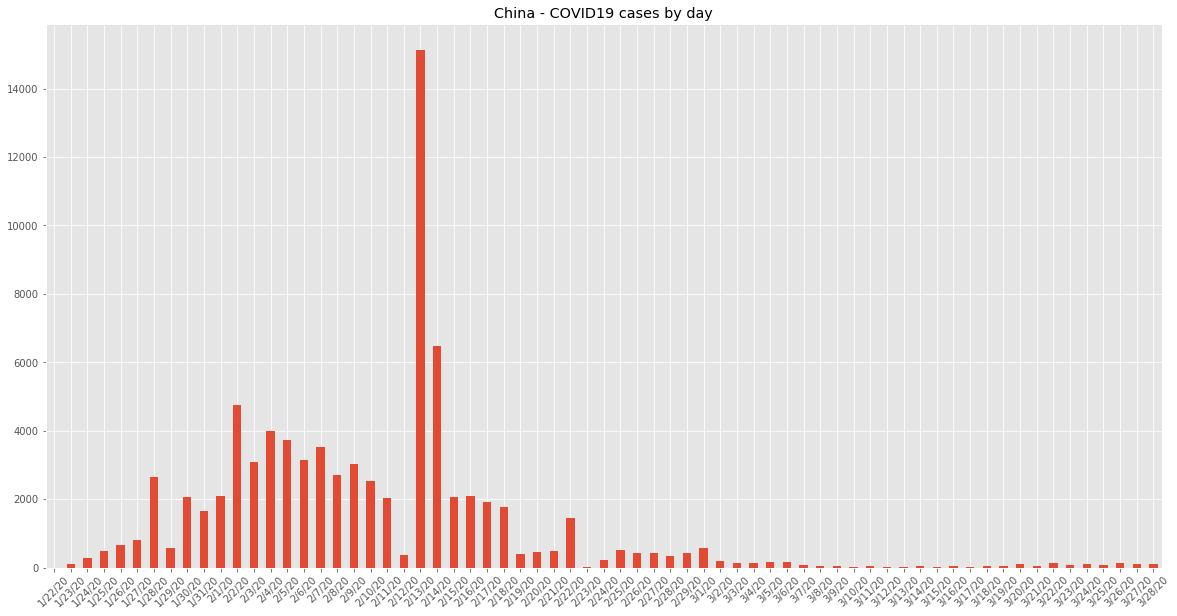

In [8]:
daily_cases_by_country('China')

In [24]:
# Chloropleth map
# ISO_alpha values for the counties had to be picked up
# from gapminder dataset, readily available in the plotly express

_df = covid_confirmed.iloc[-1]
_df = _df.transpose()
_df = _df.to_frame()
_df.reset_index(inplace=True)
_df.columns = ['country','Current_cases']
_df = pd.merge(_df,px.data.gapminder().query("year==2007"), on='country')
_df.drop(['year','lifeExp','pop','gdpPercap'], axis=1, inplace=True)

fig = px.choropleth(_df, locations="iso_alpha",
                    color="Current_cases", 
                    hover_name="country", 
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()